<a href="https://colab.research.google.com/github/involid/Computational-complexity-project/blob/main/k_cut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке будет код и анализ к задаче нахождения $k$-разреза, который приближает реальный ответ в $2 - 1/k$ раза. https://github.com/involid/Computational-complexity-project

Напомним алгоритм:


1. Для каждого ребра $e \in E$ находим наименьший разрез $s_e$, который отделяет концы $e$.

2. Сортируем полученные разрезы по возрастанию их весов. Получаем $s_1, s_2, \dots, s_m$, где $m = |E|$.
3.  Итеративно добавляем $s_i$ к искомому разрезу, пока не получим $k$-разрез.
Если $s_i \subseteq s_1 \cup s_2 \cup \dots \cup s_{i-1}$, то пропускаем данную итерацию, так как в ней нет смысла.

Будем использовать библиотеку networkx, что бы использовать готовым добром.

In [133]:
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

In [114]:
#Find min-cuts for all edges.
def make_edge(u, v):
    return (u, v) if u < v else (v, u)
def min_cuts_for_edges(G):
    cuts = []
    for edge in G.edges():
        H = nx.Graph(G)
        cut_value, (part1, part2) = nx.minimum_cut(H, edge[0], edge[1], capacity='weight')
        cut_edges = [make_edge(u, v) for u in part1 for v in part2 if H.has_edge(u, v)]
        cuts.append((cut_value, set(cut_edges)))
    return sorted(cuts, key=lambda x: x[0])

def is_subset(edg1, edg2):
    return False

# Greedily pick cuts.
def find_cuts(G_original, k):
    G = G_original.copy()
    all_cuts = min_cuts_for_edges(G)

    selected_cuts = []
    all_selected_edges = set()

    for cut_value, cut_edges in all_cuts:
        if nx.number_connected_components(G) >= k:
            break
        if is_subset(cut_edges, all_selected_edges):
            continue
        selected_cuts.append((cut_value, cut_edges))
        all_selected_edges.update(cut_edges)
        G.remove_edges_from(cut_edges)


    return selected_cuts

def find_k_cut(G, k):
    cuts = find_cuts(G, k)
    cut = set(edge for _, edges in cuts for edge in edges)
    weight = sum(G.edges[edge]['weight'] for edge in cut)
    return  weight, cut

Симплементируем еще и тупой алгоритм, работающий за экспоненциальное время, переберающий все подмножества ребер и находящий минимальный k-разрез среди них.

In [115]:
def is_k_cut(G, edges, k):
    H = G.copy()
    H.remove_edges_from(edges)
    return nx.number_connected_components(H) >= k

def find_min_k_cut(G, k):
    all_edges = list(G.edges())
    min_weight = float('inf')
    min_cut_set = None

    for r in range(1, len(all_edges) + 1):
        for edges_subset in combinations(all_edges, r):
            weight = sum(G.edges[edge]['weight'] for edge in edges_subset)
            if weight < min_weight:
                if is_k_cut(G, edges_subset, k):
                    min_weight = weight
                    min_cut_set = edges_subset

    return min_weight, min_cut_set

Немного визуализации на случайном графе.

Found minimum 3-cut is: ((0, 8), (1, 8), (4, 5), (4, 6), (4, 7), (4, 8), (7, 8))
The weight of the minimum 3-cut is: 11
Found 3-cut is: {(1, 8), (0, 9), (2, 9), (4, 8), (5, 9), (0, 8), (7, 8)}
The weight of the found 3-cut is: 12


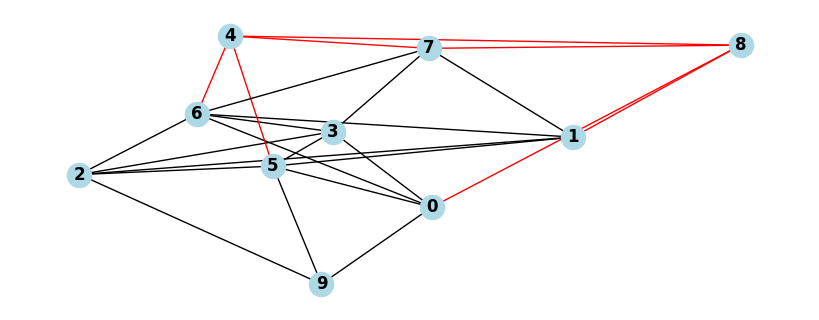

In [128]:
G = nx.erdos_renyi_graph(n=10, p=0.5)
for u, v in G.edges():
    G.edges[u,v]['weight'] = random.randint(1, 5)

k = 3

min_weight, min_k_cut = find_min_k_cut(G, k)
print(f"Found minimum {k}-cut is: {min_k_cut}")
print(f"The weight of the minimum {k}-cut is: {min_weight}")

weight, k_cut = find_k_cut(G, k)
print(f"Found {k}-cut is: {k_cut}")
print(f"The weight of the found {k}-cut is: {weight}")

plt.figure(figsize=(8, 3))
nx.draw(G, with_labels=True, font_weight='bold', node_color='lightblue',
        edge_color=['red' if edge in min_k_cut else 'black' for edge in G.edges()])
plt.show()

Как видим алгоритм дал ответ $11$, а правильный ответ $12$. Это соответствует теоретическим выкладка, что алгоритм дает приближение в $2 - 2/k$ раза, в данном примере $4/3$.

Сделаем анализ работ алгоритмов на случайных графах, со случайными весами.

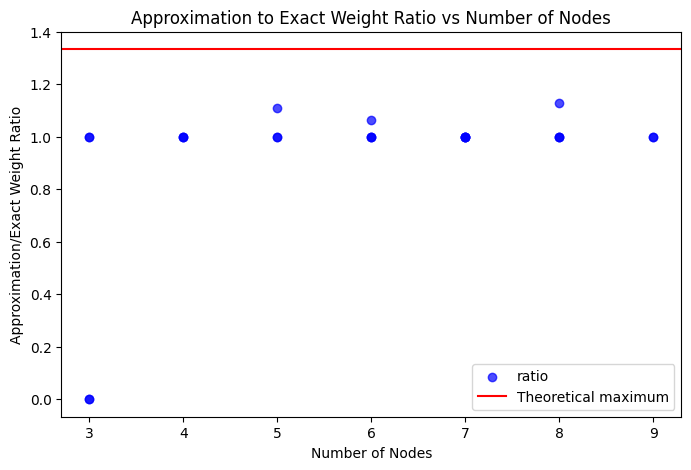

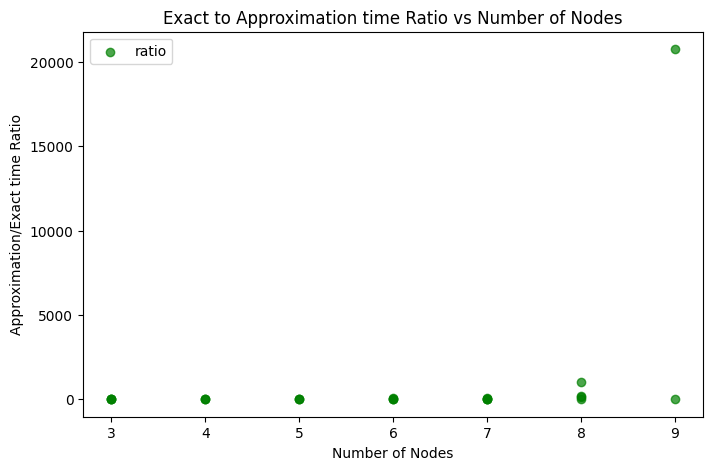

In [132]:
# find_min_k_cut vs find_k_cut
k = 3

def generate_graphs(num_graphs, max_nodes):
    graphs = []
    for _ in range(num_graphs):
        n = random.randint(k, max_nodes)
        p = random.uniform(0.5, 0.8)
        G = nx.erdos_renyi_graph(n=n, p=p)
        for u, v in G.edges():
            G.edges[u,v]['weight'] = random.randint(1, 10)
        graphs.append(G)
    return graphs

graphs = generate_graphs(num_graphs=25, max_nodes = 9)

results = []

for G in graphs:
    start_exact = time.time()
    exact_weight, exact_cut = find_min_k_cut(G, k)
    end_exact = time.time()

    start_approx = time.time()
    approx_weight, approx_cut = find_k_cut(G, k)
    end_approx = time.time()

    results.append({
        'num_nodes': len(G),
        'exact_weight': exact_weight,
        'approx_weight': approx_weight,
        'exact_time': end_exact - start_exact,
        'approx_time': end_approx - start_approx
    })


df = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.scatter(df['num_nodes'], df['approx_weight'] / df['exact_weight'], alpha=0.7, color='blue', label = 'ratio')
plt.title("Approximation to Exact Weight Ratio vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Approximation/Exact Weight Ratio")
plt.axhline(y = 2 - 2/k, color='r', linestyle='-', label="Theoretical maximum")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(df['num_nodes'], df['exact_time'] / df['approx_time'], alpha=0.7, color='green', label='ratio')
plt.title("Exact to Approximation time Ratio vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Approximation/Exact time Ratio")
plt.legend()
plt.show()


Как видим, теоретическая оценка удовлетворяется, а для $n=9$ приближающий алгоритм работает до 20000 раз быстрее, чем точный алгоритм, работающий полным перебором.